# Comparison of naive Bayes and logistic regression for text categorization

Adapted from https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

**UPDATE**: Variable `CLASS_SCI_ELECTRONICS` was corrected to `CLASS_SCI_SPACE` after the lecture. 
It was intended to point to class label 3, "sci.space"

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, log_loss
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import re

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Load subset of "20 Newsgroups" dataset

In [2]:
categories = ["misc.forsale", "sci.space", 
              "sci.electronics", "comp.graphics"]
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, 
                                  shuffle=True)
twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories, 
                                 shuffle=True)

# what's missing here? 

In [3]:
len(twenty_train.data)

2353

In [4]:
len(twenty_test.data)

1566

In [5]:
for t in twenty_train.target[:5]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
misc.forsale
misc.forsale
misc.forsale


In [6]:
y_train = twenty_train.target
y_test = twenty_test.target

## Normalize and vectorize documents

In [7]:
vectorizer = TfidfVectorizer(min_df=3, stop_words="english").fit(twenty_train.data)
X_train = vectorizer.transform(twenty_train.data)
X_test = vectorizer.transform(twenty_test.data)

In [8]:
X_train.shape

(2353, 11662)

In [9]:
for label in np.unique(y_train):
    print(f"Label {label} {twenty_train.target_names[label]:15}: {np.mean(y_train==label):.2%}")


Label 0 comp.graphics  : 24.82%
Label 1 misc.forsale   : 24.86%
Label 2 sci.electronics: 25.12%
Label 3 sci.space      : 25.20%


## Naive Bayes model

In [10]:
%%time
nb_model = MultinomialNB(alpha=1.0).fit(X_train, y_train)
y_hat_nb_test = nb_model.predict(X_test)

CPU times: user 10 ms, sys: 2.53 ms, total: 12.5 ms
Wall time: 11.7 ms


In [11]:
print(classification_report(y_test, y_hat_nb_test, 
                            target_names=twenty_train.target_names))

                 precision    recall  f1-score   support

  comp.graphics       0.86      0.91      0.88       389
   misc.forsale       0.90      0.95      0.93       390
sci.electronics       0.92      0.82      0.87       393
      sci.space       0.94      0.94      0.94       394

       accuracy                           0.91      1566
      macro avg       0.91      0.91      0.91      1566
   weighted avg       0.91      0.91      0.91      1566



In [12]:
print("Naive bayes priors:")
print(nb_model.class_log_prior_)
print(nb_model.class_log_prior_.shape)
print((np.exp(nb_model.class_log_prior_)))

Naive bayes priors:
[-1.39354541 -1.39183454 -1.38163037 -1.37825199]
(4,)
[0.2481938  0.24861878 0.25116872 0.2520187 ]


In [13]:
print("Naive bayes priors:")
print(nb_model.feature_log_prob_.shape)

Naive bayes priors:
(4, 11662)


## Logistic regression model

In [14]:
%%time
lr_model = LogisticRegression(penalty="none", 
                              multi_class="multinomial",
                              solver="lbfgs").fit(X_train, y_train)
y_hat_lr_test = lr_model.predict(X_test)

CPU times: user 1.12 s, sys: 168 ms, total: 1.29 s
Wall time: 543 ms


In [15]:
print(classification_report(y_test, y_hat_lr_test, 
                            target_names=twenty_train.target_names))

                 precision    recall  f1-score   support

  comp.graphics       0.91      0.90      0.90       389
   misc.forsale       0.95      0.92      0.93       390
sci.electronics       0.89      0.90      0.90       393
      sci.space       0.94      0.96      0.95       394

       accuracy                           0.92      1566
      macro avg       0.92      0.92      0.92      1566
   weighted avg       0.92      0.92      0.92      1566



#### Logistic regression parameters

Apply model parameters to a sample document

In [16]:
# parameters of trained model:
print(lr_model.intercept_.shape)
print(lr_model.coef_.shape)

(4,)
(4, 11662)


In [17]:
sample_text_index = 13
some_document = X_test[sample_text_index,:].todense()
print(some_document.shape)

(1, 11662)


In [18]:
linear_transform = lr_model.intercept_ + np.dot(some_document,lr_model.coef_.T)
print(linear_transform)

[[ -98.96147289 -120.47790308 -103.84366186  323.28303783]]


In [19]:
# apply soft-max 
np.exp(linear_transform)/np.exp(linear_transform).sum()

matrix([[4.18349237e-184, 1.89265771e-193, 3.17125565e-186,
         1.00000000e+000]])

In [20]:
lr_model.predict_proba(X_test[sample_text_index,:])

array([[4.18349237e-184, 1.89265771e-193, 3.17125565e-186,
        1.00000000e+000]])

In [21]:
print("Actual label:",y_test[sample_text_index])
print("Predictor label:",y_hat_nb_test[sample_text_index])
print("\n--- Actual document:")
print(twenty_test.data[sample_text_index][:300])

Actual label: 3
Predictor label: 3

--- Actual document:
From: prb@access.digex.net (Pat)
Subject: Re: Gamma Ray Bursters.  WHere  are they.
Organization: Express Access Online Communications USA
Lines: 17
NNTP-Posting-Host: access.digex.net

In article <29APR199311425584@judy.uh.edu> wingo%cspara.decnet@Fedex.Msfc.Nasa.Gov writes:
|In article <1rlrpv$5ta


## Logistic regression with L2 penalty

In [22]:
%%time
lr2_model = LogisticRegression(penalty="l2", 
                               solver="lbfgs",
                               multi_class="multinomial",
                               max_iter=1000,
                               C=10).fit(X_train, y_train)
y_hat_lr2_test = lr2_model.predict(X_test)

CPU times: user 3.04 s, sys: 441 ms, total: 3.48 s
Wall time: 1.49 s


In [23]:
print(classification_report(y_test, y_hat_lr2_test, 
                            target_names=twenty_train.target_names))

                 precision    recall  f1-score   support

  comp.graphics       0.91      0.91      0.91       389
   misc.forsale       0.93      0.96      0.94       390
sci.electronics       0.90      0.91      0.91       393
      sci.space       0.98      0.93      0.96       394

       accuracy                           0.93      1566
      macro avg       0.93      0.93      0.93      1566
   weighted avg       0.93      0.93      0.93      1566



## Comparison of train/test performance across models

In [24]:
model_info = {"Naive Bayes": nb_model,
              "Logistic Regression": lr_model,
              "L2 Regularized LR": lr2_model}
plot_data = []
for name, model in model_info.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    plot_data.append([name, "Train", train_acc])
    test_acc = accuracy_score(y_test, model.predict(X_test))
    plot_data.append([name, "Test", test_acc])  

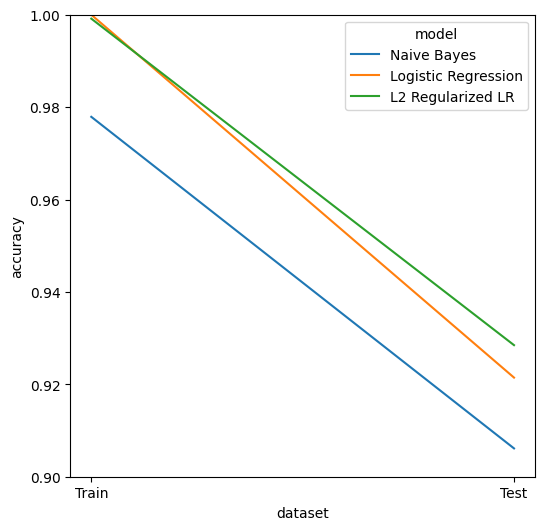

In [25]:
plt.figure(figsize=(6,6))
plt.ylim((0.9,1))
plot_df = pd.DataFrame(plot_data, columns=["model", "dataset", "accuracy"])
sns.lineplot(data=plot_df, 
             sort=False,
             x="dataset", 
             y="accuracy", 
             hue="model")
plt.show()

## Inspect model parameters


In [26]:
print("Shape of LR coefficients:",lr2_model.coef_.shape)

Shape of LR coefficients: (4, 11662)


In [27]:
print(lr2_model.coef_)

[[-1.19934524 -0.87651881 -0.09460633 ...  0.59596049 -0.16364852
  -0.16364852]
 [ 3.34657299  0.4141979  -0.06794088 ... -0.15757412 -0.06074327
  -0.06074327]
 [-1.26959221 -0.63198136 -0.12199847 ... -0.23459101  0.27292572
   0.27292572]
 [-0.87763553  1.09430227  0.28454569 ... -0.20379535 -0.04853392
  -0.04853392]]


In [28]:
vocab = sorted(vectorizer.vocabulary_.keys(), key=vectorizer.vocabulary_.get)


In [29]:
CLASS_SCI_SPACE = 3
lr_coef_sci = lr_model.coef_[CLASS_SCI_SPACE,:]

pd.DataFrame({
    "token":vocab,
    "lr_param":lr_coef_sci,
}).sort_values(by="lr_param",ascending=False).head(10)

,token,lr_param
9866,space,616.935894
7193,moon,247.756187
1386,alaska,242.199446
7722,orbit,239.037331
6404,launch,189.075027
7935,pat,182.012671
3768,digex,179.748573
7335,nasa,174.812086
1172,access,174.546989
9642,shuttle,165.646251


In [30]:
nb_coef_sci = nb_model.feature_log_prob_[CLASS_SCI_SPACE,:]

pd.DataFrame({
    "token":vocab,
    "nb_param":nb_coef_sci,
}).sort_values(by="nb_param",ascending=False).head(10)

,token,nb_param
9866,space,-6.146458
4122,edu,-6.487803
7335,nasa,-6.606961
5447,henry,-6.909549
2935,com,-6.929839
1172,access,-6.992113
1386,alaska,-7.020892
11550,writes,-7.063182
5169,gov,-7.063646
7193,moon,-7.064542


In [31]:
lr2_coef_sci = lr2_model.coef_[CLASS_SCI_SPACE,:]

pd.DataFrame({
    "token":vocab,
    "lr2_param":lr2_coef_sci,
}).sort_values(by="lr2_param",ascending=False).head(10)

,token,lr2_param
9866,space,9.156559
7722,orbit,4.090878
7193,moon,3.544038
7335,nasa,3.194587
6404,launch,2.965689
3768,digex,2.749457
3514,dc,2.612889
9382,sci,2.532593
1386,alaska,2.519521
8166,planets,2.346209


In [32]:
look_for_token = "Henry"
has_word_texts_and_labels = [(text,label)
                             for text,label in zip(twenty_train.data,twenty_train.target) 
                             if look_for_token.lower() in text.lower()]

In [33]:
sample_idx = 6 # random row id, random text to print

text, target = has_word_texts_and_labels[sample_idx]
print(f"--- LABEL: {target} '{twenty_train.target_names[target]}'\n")

print("--- TEXT:")
my_regex = rf'\b{look_for_token}\b'
printme = re.sub(my_regex,f"****{look_for_token.upper()}****", text)
print(printme)

--- LABEL: 2 'sci.electronics'

--- TEXT:
From: henry@zoo.toronto.edu (****HENRY**** Spencer)
Subject: Re: Radar detector DETECTORS?
Organization: U of Toronto Zoology
Lines: 17

In article <1993Apr20.022922.11861@julian.uwo.ca> wlsmith@valve.heart.rri.uwo.ca (Wayne Smith) writes:
>>No restriction was placed
>>on receiving RADAR (or, curiously, cordless phones.)  Enforcement
>>of the Virginia law is in violation of the FCA of 1934.
>
>Isin't there some kind of rule (regulation, law, whatever) in some
>juristictions that prohibit the use of *police band* recievers
>in vehicles?  And that radar transmissions are included in the police band 
>so they get covered by the same regulation?

Those rules/regulations/laws would be subject to the same attack:  that
they are attempting to preempt federal authority to regulate (or not)
radio communications.  Of course, as the original poster noted, court
challenges of this kind can get expensive.
-- 
All work is one man's work.             | ****HE

In [34]:
pct_sci = np.mean([label==CLASS_SCI_SPACE for text, label in has_word_texts_and_labels])
print(f"\n% Science/Electrincs for token {look_for_token}: {pct_sci:.2%}")


% Science/Electrincs for token Henry: 85.71%


## Additional experiment - L1 Penalty 

In [35]:
%%time
lr1_model = LogisticRegression(penalty="l1", 
                               solver="saga",
                               multi_class="multinomial",
                               max_iter=1000,
                               C=10).fit(X_train, y_train)
y_hat_lr1_test = lr1_model.predict(X_test)

CPU times: user 19.3 s, sys: 154 ms, total: 19.4 s
Wall time: 20.5 s


Naive Bayes          - Test: 90.61%
Logistic Regression  - Test: 92.15%
L2 Regularized LR    - Test: 92.85%
L1 Regularized LR    - Test: 89.40%


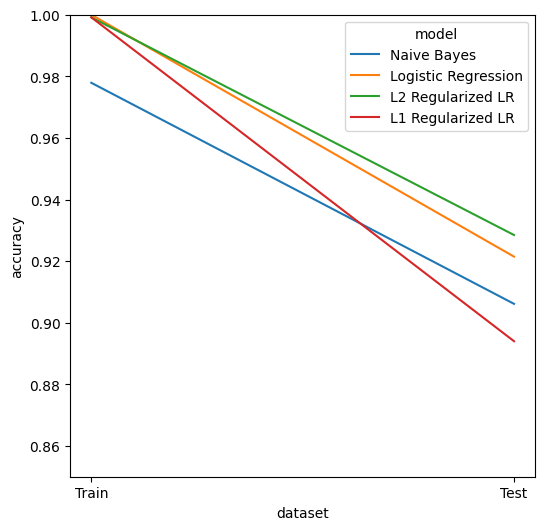

In [36]:
# add to existing `model_info`
model_info["L1 Regularized LR"]=lr1_model

plot_data = []
for name, model in model_info.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    plot_data.append([name, "Train", train_acc])
    test_acc = accuracy_score(y_test, model.predict(X_test))
    plot_data.append([name, "Test", test_acc])  
    print(f"{name:20} - Test: {test_acc:.2%}")

plt.figure(figsize=(6,6))
plt.ylim((0.85,1))
plot_df = pd.DataFrame(plot_data, columns=["model", "dataset", "accuracy"])
sns.lineplot(data=plot_df, 
             sort=False,
             x="dataset", 
             y="accuracy", 
             hue="model")
plt.show()

In [37]:

lr1_coef_sci = lr1_model.coef_[CLASS_SCI_SPACE,:]

pct_nonzero_lr1 = (lr1_coef_sci>0).mean()

print(f"% of coefficients that are non-zero: {pct_nonzero_lr1:.2%}")


% of coefficients that are non-zero: 1.24%


In [38]:
classname_sci = twenty_train.target_names[CLASS_SCI_SPACE]

print(f"non-zero L1 coefficients - {classname_sci}:")
" ".join(np.array(vocab)[lr1_coef_sci>0])

non-zero L1 coefficients - sci.space:


'accelerations actually aerospace alaska alphacdc article astronomy atmosphere aurora aviation baalke billion boom breathing bursters calpoly category centaur chrisj clementine colostate cso data dc degrees dennis dgi dietz digex doug dreams dseg ece eder egalon encoders energy envelope enzo eos ether film flb flight freed funding galileo gamma gas gene given government griffin henry het higgins ida james jennise jobs jupiter just known kuiper large launch lb level liquid long loss lunar manned mars mass matthew mccall mentorg military moon nasa news nicho nicoll observatory orbit orbital org orion otago palmer pat plane planet planets plutonium prb princeton process proton quite rights rochester rocket rocketry rockets roland rollout russian ryukoku satellite schiewer sci scicom shakala shuttle sky solar space spacecraft spacewalk sq ssto station steinly sunrise sunset sysmgr szabo telescope things thruster ti titan topaz ucsc uranium usc vacuum van venus wallacen writes xpresso yamau